# Analysis and Prediction of Golf Scores Based on the 2019 PGA Tour Season
### By Jeyanth Muthuraj and Srivatsan Srinivasan

## Introduction

Golf has been a growing sport in recent years. In 2019,  Forbes claims that there are over 47 million people who are interested in trying out the sport, which is a 6% increase from the year before. As a result, golfers are playing more than ever to improve their game and lower their scores. However, it is unclear to most golfers what they should work on. An easy answer is working on weaknesses. If one struggles with their drives, practicing driving, or if one isn’t that great of a putter, then practicing putting. Making weaknesses strengths seems like the most logical answer, but golf has a wide range of statistics that can be used to improve one’s game. Thanks to developments in technology, the PGA Tour has taken advantage of this and has used technologies like ShotLink, which uses laser and 3D mapping software to record data between different golf shots. Players can use apps that can help track their statistics and improve their scores. In this tutorial, we will track 3 common statistics in golf, and see which one is the most important of all of them. That is, if we were to hone in on one of these 3 skills, which one would yield the most improvement in one’s performance? We will look at the PGA Tour's datasets and see how a professional's statistics can match up with relatively better scores. 

## Data Processing

We will look at three common statistics: Greens in regulation, putts within 5 feet, and fairways hit. These are regarded as important statistics in the world of golf, and most professionals will be trying to improve these for the most part. Another statistic we will also look at is driving distance, which many amataeurs strive to increase, but in reality, it does not do much for one's golf performance, and we will see that shortly. 

Here, we are using the PGA Tour's website for most of our statistics. They keep their data pretty clean, so
most of the tables won't need much preprocessing once we load them in. However, when we try to create a machine
learning model, there will most likely be some extra work we need to do in order to account for missing values
(since we will be using joins to combine the tables). The code here simply uses the requests API to get the
PGA tour page, and then we use BeautifulSoup to extract the HTML elements from it. We want the table, which has the
id 'statsTable' (there is more than one table, the other one is not used for data, so it's easier to search by id).
Here we do a simply average of all the player's average scores during the 2019 season. 

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
import sklearn
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings("ignore") 

# CALCULATE AVERAGE PGA PRO SCORE

r = requests.get('https://www.pgatour.com/content/pgatour/stats/stat.120.y2019.html') # Getting the webpage
bs = BeautifulSoup(r.text, 'html.parser') # Useful for parsing
table = bs.find(id = 'statsTable') # Finding table element
d = pd.read_html(table.prettify()) # Data is pretty tidy, so not too much pre-processing to do, thanks PGA Tour!
df = d[0] # Just the way read_html works, stores tables in list. 
avg_score = df['AVG'].mean()

print("Average score among all pros: " + str(avg_score))

Average score among all pros: 70.98463297872341


Typically, par is 72 strokes, so on average pros are doing almost 1 stroke better than par, or typically as it is written on a score card, -1. That's not bad, much better than the average golfer, which is universally defined as +18 over par (AKA a bogey golfer), but not necessarily the case statistically(a harder course could have a much worse average score). Now, we want to see the pro's greens in regulation percentage. If a golfer hits a green in regulation, that essentially means they have a chance at lower their score relative to par. For example, if a hole has a par of 4, and a golfer gets onto the green in 2 strokes, that means if they putt it and get the ball in the hole, they took 3 strokes, or -1 below the par for that hole. In theory, one could get the ball in the hole from off the green, but that's not what greens in regulation is measuring. It measures how good a golfer is at getting the ball onto the green, with the constraint that they will have a chance to improve their score once they putt. So, it seems pretty natural that one would want to hit many greens in regulation, since that would maximize their chance of improving their score. We also have to consider the number of events each pro has played in. For example, if a pro played in one event and had 90% GIR, but another pro played in 10 events and had 80% GIR, then it doesn't really make sense to just look at the raw percentage, since the pro that played in one event might have gotten really lucky, while the pro whole played in 10 events played well consistently. So, we want to divide the GIR percentage by the number of events each pro has played, and then see the relation between the average score of each pro. 

Average GIR among all pros: 66.64191489361703
         PLAYER NAME     AVG      %  EVENTS
0       Rory McIlroy  69.057  68.55    19.0
1    Patrick Cantlay  69.306  67.21    21.0
2       Webb Simpson  69.377  65.81    21.0
3      Brooks Koepka  69.395  69.97    21.0
4      Justin Thomas  69.466  70.68    20.0
..               ...     ...    ...     ...
180      Seth Reeves  72.156  66.83    25.0
181  Ted Potter, Jr.  72.214  66.35    23.0
183   Martin Trainer  72.343  60.47    25.0
184         Whee Kim  72.474  66.18    27.0
185        John Chin  72.485  68.72    21.0

[162 rows x 4 columns]
SLOPE: -0.4308256841906807


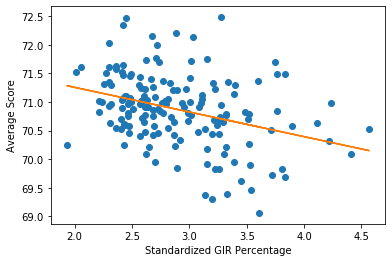

In [2]:
gir = requests.get('https://www.pgatour.com/content/pgatour/stats/stat.103.y2019.html') # Same process as before
gir_bs = BeautifulSoup(gir.text, 'html.parser')
gir_table = gir_bs.find(id = 'statsTable')
gir_data = pd.read_html(gir_table.prettify())
gir_df = gir_data[0]

events = requests.get('https://www.pgatour.com/content/pgatour/stats/stat.138.y2019.html') # Same process as before
events_bs = BeautifulSoup(events.text, 'html.parser')
events_table = events_bs.find(id = 'statsTable')
events_data = pd.read_html(events_table.prettify()) 
events_df = events_data[0]

avg_gir = gir_df['%'].mean()
print("Average GIR among all pros: " + str(avg_gir))

# Joining the tables, which will be useful for ML. We switch around between right and left depending
# on the amount of missing data in each table. 
avgscore_gir_df = df.merge(gir_df, how = 'right', left_on = 'PLAYER NAME', right_on = 'PLAYER NAME')

# Dropping unnecessary columns
avgscore_gir_df = avgscore_gir_df.drop(columns=['ROUNDS_x', 'TOTAL STROKES', 'TOTAL ADJUSTMENT', 'TOTAL ROUNDS',
                                          'ROUNDS_y', 'RELATIVE/PAR', 'RANK  THIS WEEK_x', 'RANK LAST WEEK_x',
                                         'GREENS HIT', '# HOLES', 'RANK LAST WEEK_y', 'RANK  THIS WEEK_y'])

# Joining the tables again
avgscore_gir_events_df = avgscore_gir_df.merge(events_df, how = 'left', left_on = 'PLAYER NAME', right_on = 'PLAYER NAME')

avgscore_gir_events_df = avgscore_gir_events_df.drop(columns=['RANK  THIS WEEK', 'RANK LAST WEEK',
                                                             'TOP 10', '1ST', '2ND', '3RD'])

avgscore_gir_events_df =  avgscore_gir_events_df.dropna() # Removing rows with missing entries

print(avgscore_gir_events_df)

f2 = plt.figure(2)
# Standardizing the variable since different players play a different amount of events, which could
# cause some unnecessary outliers without standardization. 
x = avgscore_gir_events_df['%']/avgscore_gir_events_df['EVENTS']
y = avgscore_gir_events_df['AVG']
plt.scatter(x, y)
plt.xlabel('Standardized GIR Percentage')
plt.ylabel('Average Score')

# Best fit line
x = pd.to_numeric(x)
y = pd.to_numeric(y)
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')

print("SLOPE: " + str(m))
plt.show()

We can see that the slope is negative, which is a good sign. This is showing that a pro's score decreases as they hit more greens in regulation, which is something that pros want to see. 

Now we want to investigate the percentage of putts made within 5 feet. It seems like a very insignificant distance, but in golf, every stroke matters. Putts within 5 feet should be made all the time by a pro, and if a pro misses, they will most likely not be happy at all about it. The chance of making a putt from over 30 feet away is very low, so the idea is that a pro would want to putt the ball into a 5 foot circle, and then since they chance of making the 5 foot putt is much greater, they can sink the putt without too much pressure. Amateur golfers however might try to make the over 30 foot putt in one stroke, in order to improve their score. Not only is that quite unlikely, but they are more bound to mess up and will probably not end up within 5 feet of the hole like pros want to do. So, here we want to see the average score is related to the percetange of putts made within 5 feet. 

         PLAYER NAME     AVG      %  EVENTS  % MADE
0       Rory McIlroy  69.057  68.55    19.0   88.75
1    Patrick Cantlay  69.306  67.21    21.0   87.94
2       Webb Simpson  69.377  65.81    21.0   88.48
3      Brooks Koepka  69.395  69.97    21.0   88.69
4      Justin Thomas  69.466  70.68    20.0   87.05
..               ...     ...    ...     ...     ...
157      Seth Reeves  72.156  66.83    25.0   86.18
158  Ted Potter, Jr.  72.214  66.35    23.0   85.44
159   Martin Trainer  72.343  60.47    25.0   88.22
160         Whee Kim  72.474  66.18    27.0   88.95
161        John Chin  72.485  68.72    21.0   86.18

[162 rows x 5 columns]
SLOPE: -0.2893555939382997


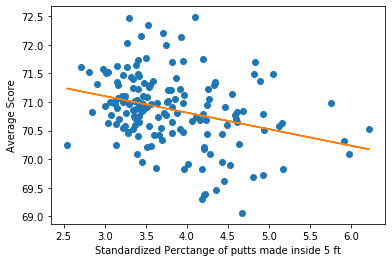

In [3]:
putts = requests.get('https://www.pgatour.com/content/pgatour/stats/stat.484.y2019.eoff.t060.html') # Same process as before
putts_bs = BeautifulSoup(putts.text, 'html.parser')
putts_table = putts_bs.find(id = 'statsTable')
putts_data = pd.read_html(putts_table.prettify())
putts_df = putts_data[0]

# Merging, and dropping columns/missing entries
main_putt_df = avgscore_gir_events_df.merge(putts_df, how = 'right', left_on = 'PLAYER NAME', right_on = 'PLAYER NAME')

main_putt_df = main_putt_df.drop(columns = ['RANK  THIS WEEK', 'RANK LAST WEEK',
                              'ATTEMPTS', 'PUTTS MADE', 'ROUNDS'])

main_putt_df = main_putt_df.dropna()

print(main_putt_df)

f3 = plt.figure(3)
# Standardizing for same reason as before
x2 = main_putt_df['% MADE']/main_putt_df['EVENTS']
y2 = main_putt_df['AVG']
plt.scatter(x2, y2)
plt.xlabel('Standardized Perctange of putts made inside 5 ft')
plt.ylabel('Average Score')

# Best fit line
x2 = pd.to_numeric(x2)
y2 = pd.to_numeric(y2)
b2, m2 = polyfit(x2, y2, 1)
plt.plot(x2, y2, '.')
plt.plot(x2, b2 + m2 * x2, '-')
print("SLOPE: " + str(m2))
plt.show()

The slope is still decreasing which is good as stated before, but it's not as steep as the GIR slope(just compare -0.431 and -0.289). However, this still suggests that making more putts within 5 feet will improve a pro's score. 

Now we will investigate the percentage of fairways hit. This simply means that when a pro hits a drive, what's their percentage of being in the fairway? The fairway is thin grass that makes it much easier to hit good shots from. Pros can utilize techniques such as spin control with more success than they can from thicker, tougher grass. Inherently, it's easiest to hit a green in regulation from the fairway, so we expect to see that this statistic does have some effect on a pro's score. Let's take a look at the relationship between a pro's average score and their fairway percentage. 

In [4]:
fairway = requests.get('https://www.pgatour.com/content/pgatour/stats/stat.102.y2019.html') # Same as before
fairway_bs = BeautifulSoup(fairway.text, 'html.parser')
fairway_table = fairway_bs.find(id = 'statsTable')
fairway_data = pd.read_html(fairway_table.prettify()) 
fairway_df = fairway_data[0]

# Merging, renaming columns for readability, and dropping columns/missing entries
main_fairway_df = main_putt_df.merge(fairway_df, how = 'left', left_on = 'PLAYER NAME', right_on = 'PLAYER NAME')
main_fairway_df = main_fairway_df.rename(columns={"%_x": "GIR", "%_y": "FAIRWAYS"})
main_fairway_df = main_fairway_df.dropna()
main_fairway_df = main_fairway_df.drop(columns=['RANK  THIS WEEK', 'RANK LAST WEEK', 'ROUNDS',
                                              'FAIRWAYS HIT','POSSIBLE FAIRWAYS'])

print(main_fairway_df)

f4 = plt.figure(4)
# More standardization
x3 = main_fairway_df['FAIRWAYS']/main_fairway_df['EVENTS']
y3 = main_fairway_df['AVG']
plt.scatter(x3, y3)
plt.xlabel('Standardized Perctange of fairways hit')
plt.ylabel('Average Score')

# Best fit line
x3 = pd.to_numeric(x3)
y3 = pd.to_numeric(y3)
b3, m3 = polyfit(x3, y3, 1)
plt.plot(x3, y3, '.')
plt.plot(x3, b3 + m3 * x3, '-')
print("SLOPE: " + str(m3))
plt.show()

AttributeError: 'NoneType' object has no attribute 'prettify'

The slope is steeper than the putts slope, but not as steep as the greens in regulation slope. Still, a good sign since hitting fairways more fairways shows a decrease in average score. 

Now, we just looked at 3 statistics that seem to affect a pro's score in a positive way. Now let's take a look at a statistic that many amaeturs want to maximize, driving distance. Every novice golfer wants to be able to drive the ball 300 yards like all the pros. However, many don't realize that distance doesn't matter nearly as much in golf as consistency. The 3 statistics above are all consistency statistics. They're all percentages, measuring how often a pro achieves that statistic. Driving distance, can be considered a consistency statistic, but clearly being able to drive the ball 300 yards should not be as important as having more chances at improving your score(greens in regulations). Here, we will see how the average driving distance of a pro is related to the average score for a pro.

In [ ]:
distance = requests.get('https://www.pgatour.com/content/pgatour/stats/stat.101.y2019.html') # Same as before....
distance_bs = BeautifulSoup(distance.text, 'html.parser')
distance_table = distance_bs.find(id = 'statsTable')
distance_data = pd.read_html(distance_table.prettify())
distance_df = distance_data[0]
distance_df = distance_df.rename(columns={"AVG." : "DISTANCE"}) # Confusing column name, so renaming

# Merging and only dropping columns, no rows with missing entries this time
main_df = main_fairway_df.merge(distance_df, how = 'left', left_on = 'PLAYER NAME', right_on = 'PLAYER NAME')
main_df = main_df.drop(columns=['RANK  THIS WEEK', 'RANK LAST WEEK','ROUNDS','TOTAL DISTANCE', 'TOTAL DRIVES']) 

print(main_df)

f5 = plt.figure(5)
# Standardization
x4 = main_df['DISTANCE']/main_df['EVENTS']
y4 = main_df['AVG']
plt.scatter(x4, y4)
plt.xlabel('Standardized Driving distance')
plt.ylabel('Average Score')

# Best fit line
x4 = pd.to_numeric(x4)
y4 = pd.to_numeric(y4)
b4, m4 = polyfit(x4, y4, 1)
plt.plot(x4, y4, '.')
plt.plot(x4, b4 + m4 * x4, '-')
print("SLOPE: " + str(m4))
plt.show()

As you can see, the slope is significantly worse than all the other slopes for the 3 main statistics. Distance does matter for pros, but it clearly doesn't matter as much as the other statistics, so amateurs need to focus on consistency vs power.

## Machine Learning and Predictive Analysis

For each statistic, we've appended the statistic to a main table that will be used for machine learning. As an aspiring professional golf player, such an individual would be interested in learning what combinations of certain golf playing features would lead to a higher average score. From a data science perspective, creating a function based on a linear regression model that would take as input the features of greens in regulation, number of events, percentage of putts made, fairways made, and driving distance and outputting a predicted average score would be beneficial to the improvement of the golf player. Furthermore, the player can play around with the parameters to understand whether a certain metric of their golf game has a higher impact than others.

### Linear Regression Model

First, to determine if there in fact exists a relationship between the golf playing features listed above and the average golf score, we analyze the correlation coefficients among all variables. In the first line of the following correlation coefficient table, we notice that all of the r values show a rather moderately strong relationship with the average score (overall values between 0.15 and 0.33). Therefore, due to reasonable correlation coefficients, continuing on with creating a linear regression model to outline the relationship is appropriate.

In [ ]:
# Finding correlation coefficients
print(main_df.corr()) # look at AVG column for correlation coefficients

In [6]:
# Linear regression model for predicting a golf player's average score
# Features used for prediction: Greens in Regulation, Number of Events, Percentage of Putts Made, Fairways Made, Driving Distance Made
features_df = main_df.drop(columns = ['PLAYER NAME', 'AVG'])
# Target of prediction: Average Score
target_df = main_df.drop(columns = ['PLAYER NAME', 'GIR', 'EVENTS', '% MADE', 'FAIRWAYS', 'DISTANCE'])

# Training Data
X = features_df
y = target_df['AVG']

# Fit Linear Regression Model
lm = linear_model.LinearRegression()
lm = lm.fit(X, y)

# Scatter Plot for Residual Analysis (Linear Regression Model)
lm_predictions = lm.predict(X)
residuals = main_df['AVG'] - lm_predictions
residuals_df = pd.DataFrame(residuals).reset_index()
ax = sns.lmplot(x = 'index', y = 'AVG', data = residuals_df, fit_reg = True)
ax.set(ylabel='residuals')
plt.title('Residual Analysis of Linear Regression Model')
plt.show()

NameError: name 'residuals_df' is not defined

The scatter plot indicates a positive slope which is indicative a linear regression model that can be rather improved. In other words, the linear regression model residuals should be as close to 0 as possible with a slope as close to 0 to show a model that effectively predicts average scores.

To analyze the strength of the model, we look to printing out a summary statistics table and analyzing the coefficient of determination:

In [ ]:
# Print Statistical Summary for Linear Regression Model Fit
model_x = sm.add_constant(X)
model = sm.OLS(y, model_x)
model_statistics = model.fit()
print(model_statistics.summary())

The R-squared value for the linear regression model is 0.433. This indicates that 43.4% of the variation in average 
golf score can be attributed to that of the independent variables: Greens in Regulation, Numver of Events, Percentage 
of Putts Made, Fairways Made, Driving Distance Made.

### Random Forest Model

After analyzing the various correlation coefficients between average golf scores and predictive features,
greens in regulation vs. average golf score conveys the highest correlation coefficient (-0.333). This suggests
that the relationships between greens in regulation and average golf score is a rather moderately strong and 
negative correlation. Since lower golf scores are favored, creating a random forest model of this relationship
seems reasonable and useful for aiding an aspiring golf professional. Specifically, this specific model will determine if a player's average score is greater than the Pro Golfer Average for 2019 given the player's greens in regulation.

In [ ]:
# Random forest model to determine if a player's average score is greater than the Pro Golfer Average for 2019 given the player's greens in regulation
# Reformatting of average score into appropriate dimensions and a binary classification dependent on whether the value > pro golfer average
avg_score_df = pd.DataFrame(main_df['AVG']).as_matrix().flatten()
avg_score_df = np.array([1 if x >= main_df['AVG'].mean() else 0 for x in avg_score_df]).reshape(-1, 1)

# Reformatting of greens in regulation column
gir_df = pd.DataFrame(main_df['GIR']).as_matrix().flatten().reshape(-1, 1)

# Fit Random Forest Model
random_forest = RandomForestClassifier(n_jobs = -1).fit(gir_df, avg_score_df)
random_forest_statistics = sklearn.model_selection.cross_val_score(random_forest, gir_df, avg_score_df, cv = 10)

# Use random forest model to predict whether player's average score will be greater or less than the 2019 Pro Golfer Average
# Format both prediction data and ground truth for residual analysis
rf_predictions = random_forest.predict(gir_df)
rf_predictions_df = pd.DataFrame(rf_predictions, columns = ['rf_predict'])
avg_score_predictions_df = pd.DataFrame(avg_score_df.flatten(), columns = ['avg_score_predict'])

# Scatter Plot for Residual Analysis (Random Forest Model)
rf_residuals = avg_score_predictions_df['avg_score_predict'] - rf_predictions_df['rf_predict']
rf_residuals_df = pd.DataFrame(rf_residuals, columns = ['residuals']).reset_index()
sns.lmplot(x = 'index', y = 'residuals', data = rf_residuals_df, fit_reg = True)
plt.title('Residual Analysis of Random Forest Model')

The scatter plot indicates a slope that approaches that of 0. This suggests that the random forest model provides a great representation for predicting whether a player's average score is greater than the 2019 Pro Golfer Average because the vast majority of residual points surround 0 (meaning that predictions match ground truth values).

### Predictive Functions

To be used at ease by an aspiring golf player, we have implemented functions for both the linear regression model and the random forest model to be used by the user to output average score predictions based on certain golf playing metrics. For reiteration, the linear regression model will take in as input the greens in regulation percentage, the number of events player, the percentage of putts made, the percentage of fairways made, and the average driving distance, and output a predicted average score. Similarly, the random forest model will take as input only the greens in regulation percentage and output whether the user will have an average score greather than or less than that of the average score for golf professionals on the 2019 PGA Season.

In [ ]:
# Function to predict average score using linear regression model
def predict_avg_score_linear(gir, num_events, percent_made, fairways_made, driving_distance):
    features_df = pd.DataFrame([[gir, num_events, percent_made, fairways_made, driving_distance]], columns = ['GIR', 'EVENTS', '% MADE', 'FAIRWAYS', 'DISTANCE'])
    predictions = lm.predict(features_df)
    
    return "Average score is predicted to be " + str(predictions[0])

print("Linear Regression Model: " + predict_avg_score_linear(68.55, 19.0, 88.75, 61.82, 313.5)) # Prediction using Rory McIlroy performance data

# Function to predict whether a player's average score is greater than the Pro Golfer Average for 2019 given the player's greens in regulation
def predict_avg_score_random_forest(gir):
    features_df = pd.DataFrame([[gir]], columns = ['GIR'])
    predictions = random_forest.predict(features_df)
    
    if (predictions[0] == 0):
        return "Average score is predicted to be below that of the average pro golf player (< 70.985)"
    else:
        return "Average score is predicted to be above that of the average pro golf player (> 70.985)"

print("Random Forest Classification: " + str(predict_avg_score_random_forest(68.55))) # Prediction using Rory McIlroy performance data

As an example, we examine the predictions of Rory McIlroy's average scores with that of his real average score from the 2019 PGA Season. Rory McIlroy's true average score for the 2019 PGA Season was 69.057. Both the linear regression model and the random forest model are successful in predicting an average score of 69.695 and an average score that is below that of the average pro golf player (less than 70.985) respectively.

## Conclusion

The goal was to find the most important statistic for a player to work on in order to improve their scores. From the first part of the analysis, we found that pros had a greater improvement in their score when they had a better greens in regulation percentage, but the other 3 statistics were also of importance as well. For example, you can hit a green and have a chance at improving your score, but if you can't putt well, then the chance of you getting below par for that hole is instantly lower. Inherently, improving green in regulation percentage is a vague task. There are many, many other statistics that the PGA Tour keeps track of, and many of the statisics can be related to improving one's GIR percentage, such as statistics with particular golf clubs besides the putter. It's also important to focus on every aspect of the game and not just soley one, but here we wanted to see the statistic that players should keep track of if they want to record and improve their performance. 

We got all of our data from the PGA Tour, which consisted of professional data. This seems a bit weird since we want to be able to tell what the average player should work on. However, professionals are in the PGA Tour for a reason, they're good. They know what to focus on, and if an average player wants to improve themselves, they should also look at what a pro works on, since their strategy got them to the PGA Tour, which is no easy feat. In general, it's okay that the data here is not from the average golfer, since the average golfer can learn from the statistics of a professional golfer.

After realizing what metrics and statistics were of importance, we realized that creating a model that could let an improving golfer predict their average score based on these metrics would be invaluable. For instance, both the models that we implemented would allow the user to input various metrics including greens in regulation percentage, the number of events player, the percentage of putts made, the percentage of fairways made, and the average driving distance, and give the user immediate information on how this would translate to an average score. Furthermore, the user can also use the function to alter various parameters to understand if improving one golf skill can out balance a lack in another skill. Not all golfers play in the same uniform fashion, thus providing a method for aspiring golfers to understand how to improve their game on various metrics that are supported by data from professional golfers is an asset that is both efficient, accurate, and helpful.